# Rede Neural com uma camada escondida, reLU e Softmax no Keras - Iris dataset

Este notebook é uma cópia do anterior, porém, no modelo é adicionado uma camada e uma ativação não linear denominada reLU.

Agora a rede neural começa a poder separar melhor as fronteiras de decisão, não apenas por segmentos de retas, mas formas não lineares, dando maior flexibilidade na montagem das fronteiras de decisão.

In [28]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import load_iris

np.random.seed(12345)

import keras
from keras.utils import np_utils 
from keras.models import Sequential 
from keras.layers import Dense, Activation 
from keras.optimizers import SGD

from keras.callbacks import Callback
from IPython import display

## Leitura, normalização e visualização dos dados

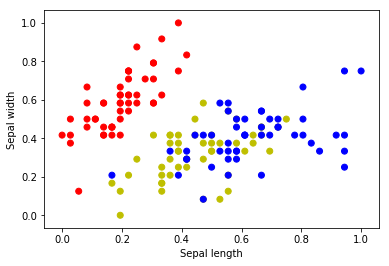

In [29]:
iris = load_iris()
X = iris.data[:,:2]  # comprimento das sépalas e pétalas, indices 0 e 2
Xc = X - X.min(axis=0)
Xc /= Xc.max(axis=0)

Y = iris.target
colors = np.array(['r','y','b'])
plt.scatter(Xc[:, 0], Xc[:, 1], c=colors[Y])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

## Conversão dos rótulos para o formato one-hot encoding

In [30]:
from keras.utils import np_utils 
Y_oh = np_utils.to_categorical(Y, 3) 
print Y[0:5]
print Y_oh[0:5]

[0 0 0 0 0]
[[ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]]


## Construindo o modelo da rede

Para se criar mais camadas no modelo da Regressão Logística visto até agora, precisamos colocar um elemento não linear, caso contrário, a concatenação de não elementos lineares é equivalente a um único elemento linear.

Um dos elementos não lineares mais eficientes e mais utilizados hoje em dia é o denominado `reLU` - *Rectifier Linear Unit*. Para valores negativos de entrada, a saída é zero, para valores positivos, a saída é a mesma.

Uma questão importante, que não será discutida neste curso é que para se realizar o cálculo do gradiente, primeiro é importante notar que o gradiente do reLU é muito simples assim como a concatenação dos gradientes de cada camadas. Na prática é utilizada a técnica denominada *backpropagation* para atualizar o gradiente de toda a rede de forma extremamente eficiente.

![](../figures/2camadas.jpg)

A implementação no Keras de inserção de uma nova camada é muito simples. No exemplo colocamos uma camada escondida de 5 neurônios:

In [50]:
output_dim = nb_classes = 3 
model = Sequential() 

model.add(Dense(5, input_dim=2, activation='relu'))
model.add(Dense(5, activation='tanh'))
model.add(Dense(output_dim, activation='softmax')) 

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_25 (Dense)                 (None, 5)             15          dense_input_10[0][0]             
____________________________________________________________________________________________________
dense_26 (Dense)                 (None, 5)             30          dense_25[0][0]                   
____________________________________________________________________________________________________
dense_27 (Dense)                 (None, 3)             18          dense_26[0][0]                   
Total params: 63
Trainable params: 63
Non-trainable params: 0
____________________________________________________________________________________________________


## Compilação do modelo

In [42]:
sgd = SGD(lr=0.5)
model.compile(optimizer=sgd, loss='categorical_crossentropy') 

## Callback para visualização dinâmica

In [43]:
class BoundaryPlotter(Callback):
    def __init__(self,X,Y,n_epoch, filepath=None,h = .01):
        self.X = X
        self.Y = Y
        self.n_epoch = n_epoch
        self.filepath = filepath
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        self.loss_hist = []
        self.val_loss_hist = []
        self.X_grid = np.c_[self.xx.ravel(), self.yy.ravel()]
        
        
    def on_epoch_end(self,epoch, logs={}):
        if 'loss' in logs.keys():
            self.loss_hist.append(logs['loss'])
            if epoch%1000==0: 
                plt.subplot(121)
                plt.plot(np.arange(epoch+1),self.loss_hist,'b',linewidth = 2.0)
                plt.subplot(122)
                Z = self.model.predict_classes(self.X_grid,verbose=0).reshape(self.xx.shape)
                plt.figure(1, figsize=(4, 3))
                plt.pcolormesh(self.xx, self.yy, Z, cmap=plt.cm.Paired)
                colors = np.array(['r','y','b'])
                plt.scatter(self.X[:, 0], self.X[:, 1], s=400, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)
                
                display.display(plt.gcf())
                display.clear_output(wait=True)
                

## Laço principal de treinamento da Regressão Logística por Softmax

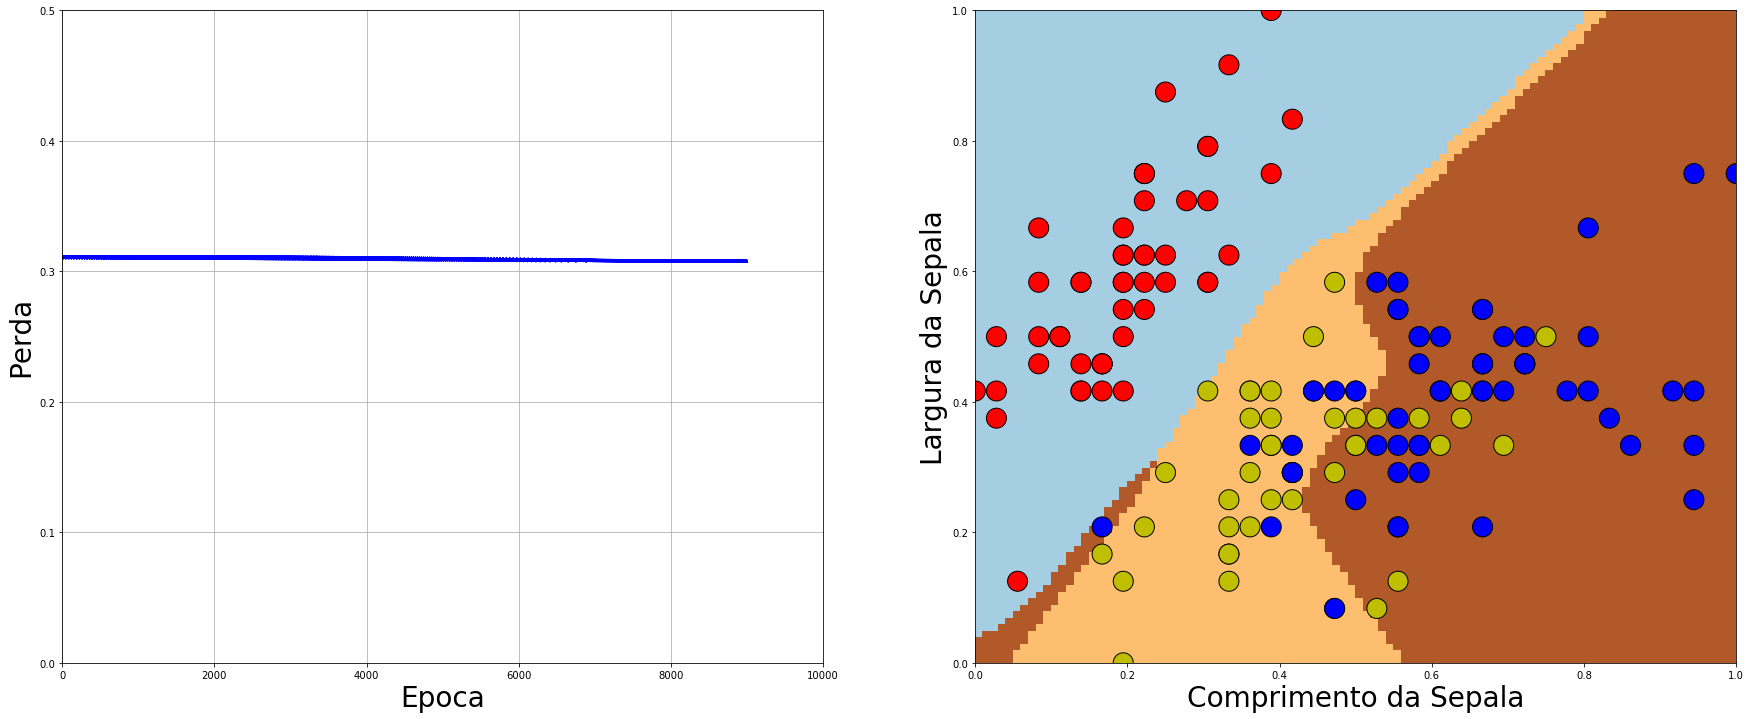

In [46]:
batch_size = 150
nb_epoch = 10000

#Definindo o callback
boundary_plot = BoundaryPlotter(Xc,Y,nb_epoch)

#Gráficos a serem mostrados pelo callback
ploss = 0.5
fig = plt.figure(figsize=(30,12))
plt.subplot(121)
#plt.plot(0.0,ploss)
plt.ylim(0.0, ploss)
plt.xlim(0, nb_epoch)
plt.xlabel('Epoca',fontsize=28)
plt.ylabel('Perda',fontsize=28)
plt.plot(-1,-1,'b',linewidth = 2.0,label = "Treino")
plt.grid(True)

plt.subplot(122)
plt.xlim(Xc[:,0].min(), Xc[:,0].max())
plt.ylim(Xc[:,1].min(), Xc[:,1].max())
plt.xlabel('Comprimento da Sepala',fontsize=28)
plt.ylabel('Largura da Sepala',fontsize=28)

n = Xc.shape[0] # number of training examples

try:
    history = model.fit(Xc, Y_oh, batch_size=batch_size, nb_epoch=nb_epoch,callbacks = [boundary_plot],verbose=0)
except KeyboardInterrupt:
    pass


## Imprimindo loss e W finais

In [47]:
loss = model.evaluate(Xc, Y_oh, verbose=0)
print 'Final loss:',loss

W = model.get_weights()
print 'Bias:\n', W[1]
print 'W:\n', W[0]

Final loss: 0.307857884735
Bias:
[-0.37020883  0.73264837 -0.27682605 -1.51655221 -0.05027771]
W:
[[-0.40519378 -4.84391928  6.5858717   3.37962747 -0.71247071]
 [ 0.52703393  5.71973562 -2.78796959  3.07096148  0.20640929]]


## Avaliação do classificador

In [48]:
Y_hat = model.predict_classes(Xc)
accuracy = sum(Y_hat == Y)/(float(len(Y)))
print 
print 'Training Accuracy: ', accuracy

print 'Matriz de confusão:'
import pandas as pd
pd.crosstab(Y_hat, Y)

 32/150 [=====>........................] - ETA: 0s
Training Accuracy:  0.813333333333
Matriz de confusão:


col_0,0,1,2
row_0,,,
0,50,0,0
1,0,31,9
2,0,19,41


## Atividades


### Experimentos:
1. Troque os atributos utilizados no `X` por outros dois, por exemplo o primeiro é segundo:
    `X = iris.data[:,:2]  # comprimento e largura das sépalas, indices 0 e 1` e observe o comportamento do classificar e as fronteiras de decisão.
2. Coloque mais uma camada escondida e observe o comportamento das fronteiras de decisão para o problema anterio.



## Principais aprendizados

1. Mais camadas n-lineares podem causar sobre-ajuste
2. Falta de conjuntos de validação e teste são fundamentais na eficiência do classificador
3. N camadas lienares = 1 camada linear
4. Retropropagation: model.compile